### Project Rubric

|평가문항|상세기준|
|:--|:--|
|1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?|ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.|
|2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?|CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.|
|3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?|CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.|

### INDEX

1. 데이터 로드 및 전처리
2. 모델 구축 및 학습 
3. CAM feature map 확인
4. grad-CAM feature map 확인
5. CAM vs grad-CAM
6. Draw bbox
7. Calculate IOU
8. (additional) trainded model with cutmix 
9. 실패노트

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image


In [3]:
tfds.__version__

'4.4.0'

### 데이터 로드 및 전처리

In [437]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [8]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


### 모델 구축 및 학습

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output

def ADD_YOUR_DENSE_LAYER(x):
    x = tf.keras.layers.Dense(num_classes, activation = 'softmax')(x)
    return x
    
preds = ADD_YOUR_DENSE_LAYER(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [4]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

conv5_block3_out (Activation)의 출력값이 feature map으로 사용됨

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

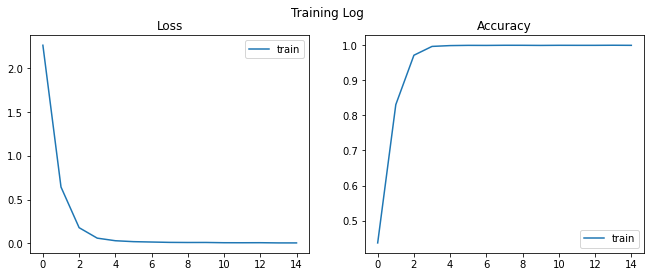

In [203]:
fig, ax = plt.subplots(1,2, figsize=(11,4))
fig.suptitle('Training Log')

ax[0].plot(range(len(history_cam_model.history['loss'])), history_cam_model.history['loss'], label = 'train')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(range(len(history_cam_model.history['accuracy'])), history_cam_model.history['accuracy'], label = 'train')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [8]:
# Q. '/aiffel/class_activation_map' 에 'cam_model1.h5'을 저장

import os

cam_model_path = '/aiffel/class_activation_map'

cam_model.save('cam_model1.h5')

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### CAM feature map 확인

In [10]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


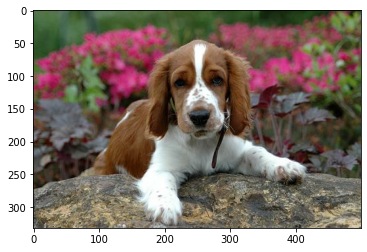

In [22]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [199]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [33]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

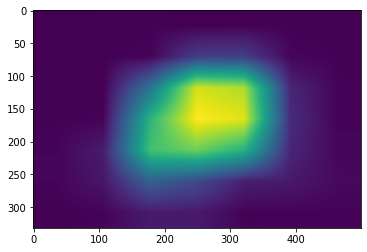

In [204]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [34]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

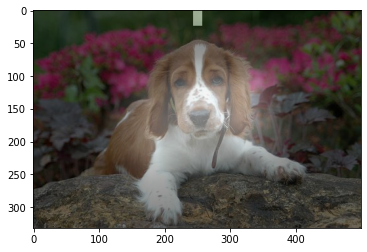

In [206]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### Grad-CAM feature map 확인

116


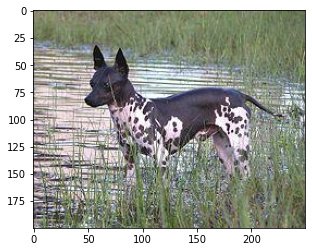

In [331]:
# item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [35]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

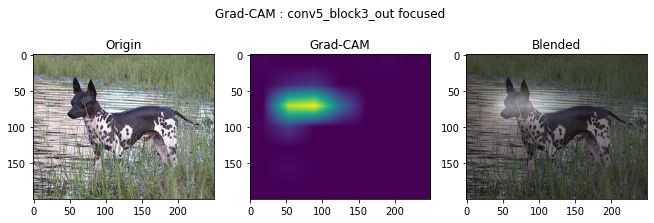

In [332]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
grad_cam_image_3ch = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(grad_cam_image_3ch, origin_image)

fig, ax = plt.subplots(1,3, figsize=(11,4))
fig.suptitle(f'Grad-CAM : conv5_block3_out focused', fontsize = 12)
fig.subplots_adjust(top=1.0)
ax[0].imshow(origin_image)
ax[0].set_title('Origin')
ax[1].imshow(grad_cam_image)
ax[1].set_title('Grad-CAM')
ax[2].imshow(blended_image)
ax[2].set_title('Blended')
# fig.tight_layout()

plt.show()

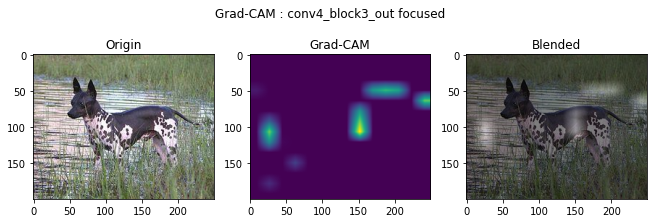

In [333]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
grad_cam_image_3ch = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(grad_cam_image_3ch, origin_image)

fig, ax = plt.subplots(1,3, figsize=(11,4))
fig.suptitle(f'Grad-CAM : conv4_block3_out focused', fontsize = 12)
fig.subplots_adjust(top=1.0)
ax[0].imshow(origin_image)
ax[0].set_title('Origin')
ax[1].imshow(grad_cam_image)
ax[1].set_title('Grad-CAM')
ax[2].imshow(blended_image)
ax[2].set_title('Blended')
# fig.tight_layout()

plt.show()

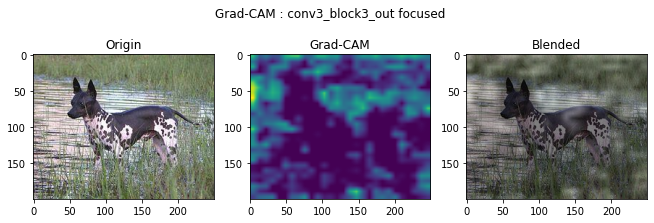

In [334]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
grad_cam_image_3ch = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(grad_cam_image_3ch, origin_image)

fig, ax = plt.subplots(1,3, figsize=(11,4))
fig.suptitle(f'Grad-CAM : conv3_block3_out focused', fontsize = 12)
fig.subplots_adjust(top=1.0)
ax[0].imshow(origin_image)
ax[0].set_title('Origin')
ax[1].imshow(grad_cam_image)
ax[1].set_title('Grad-CAM')
ax[2].imshow(blended_image)
ax[2].set_title('Blended')
# fig.tight_layout()

plt.show()

특정 대상을 향해 focus가 좁혀지는 느낌이 듦

### CAM vs Grad-CAM

In [39]:
cam_model = tf.keras.models.load_model('./cam_model1.h5')

80


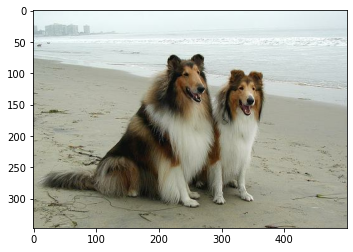

In [62]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

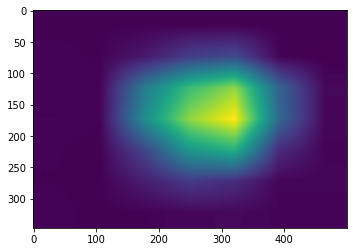

In [63]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

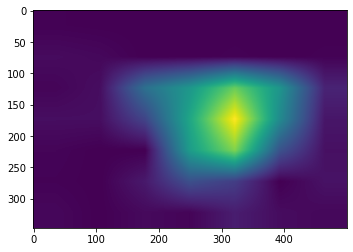

In [64]:
image = copy.deepcopy(item['image'])
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [65]:
sum(sum(cam_image==grad_cam_image)) # 값은 같지 않지만 유사하게 보임

0

In [66]:
origin_image = item['image'].astype(np.uint8)

grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

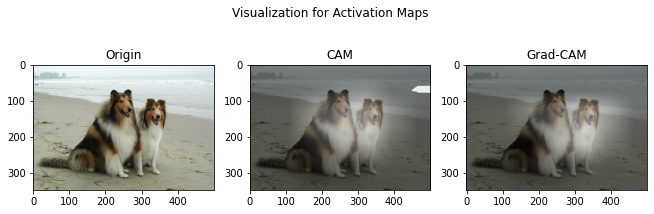

In [67]:
fig, ax = plt.subplots(1,3, figsize=(11,4))
fig.suptitle(f'Visualization for Activation Maps', fontsize = 12)
fig.subplots_adjust(top=1.0)
ax[0].imshow(origin_image)
ax[0].set_title('Origin')
ax[1].imshow(blended_image)
ax[1].set_title('CAM')
ax[2].imshow(grad_blended_image)
ax[2].set_title('Grad-CAM')
plt.show()

In [129]:
def show():
    # 이미지 호출
    item = get_one(ds_test)
    origin_image = item['image'].astype(np.uint8)

    # CAM, grad-CAM 생성
    cam_image = generate_cam(cam_model, item)
    grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

    # 3channel화
    grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
    cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

    # 이미지 합성
    blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
    grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

    # 시각화
    fig, ax = plt.subplots(2,3, figsize=(11,5))
    fig.suptitle(f'Visualization for Activation Maps', fontsize = 12)
    ax[0][0].imshow(origin_image)
    ax[0][0].set_title('Origin')
    ax[0][1].imshow(blended_image)
    ax[0][1].set_title('CAM')
    ax[0][2].imshow(grad_blended_image)
    ax[0][2].set_title('Grad-CAM')
    ax[1][0].imshow(origin_image)
    ax[1][0].set_title('Origin')
    ax[1][1].imshow(cam_image)
    ax[1][1].set_title('CAM heatmap')
    ax[1][2].imshow(grad_cam_image)
    ax[1][2].set_title('Grad-CAM heatmap')
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=.87, wspace=0.2, hspace=0.45)
    plt.show()

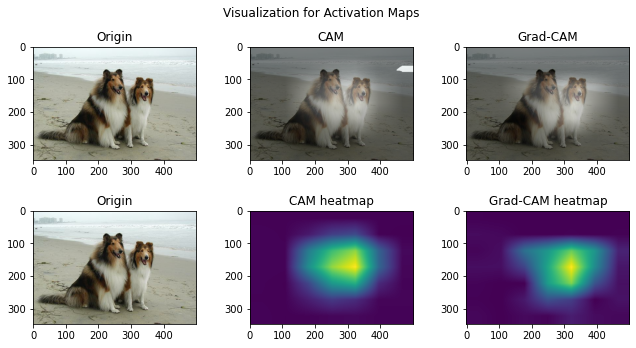

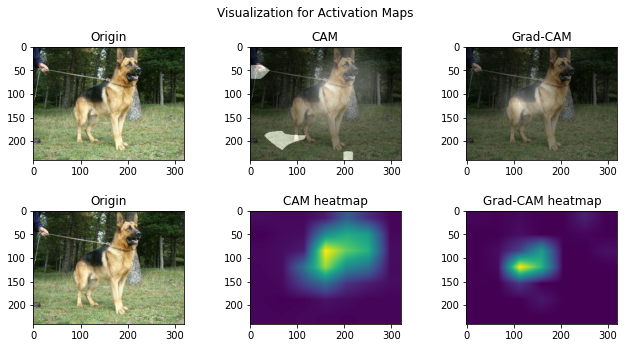

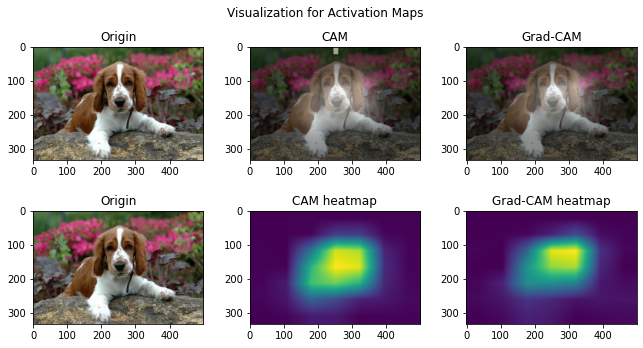

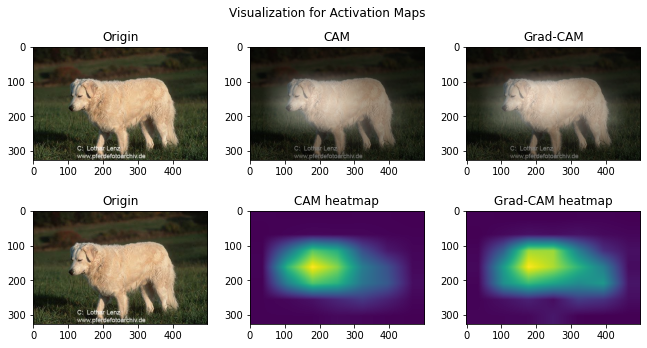

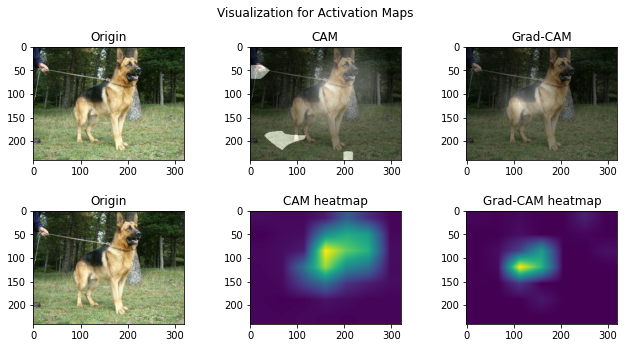

In [130]:
for _ in range(5):
    show()

CAM은 마지막 convolution의 feature map으로부터(convolution layer는 상위로 갈 수록 보다 broad한 feature를 뽑음) 얻은 GAP values을 이용하여 보다 넓은 범위에서 검출(특정)하고자 하고자 하는 값에 집중함.

Grad-CAM은 거기에 positive gradients를 사용해서 그런지 좀 더 국소적인 면을 중점으로 focusing 하는 느낌을 받음

### Draw bbox

40


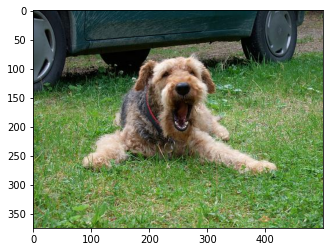

In [313]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [311]:
def get_points(image, bbox):
    bbox = item['objects']['bbox']

    # 이미지 크기
    image_height, image_width = item['image'].shape[:2]

    # 좌표 변환 (정규화된 좌표를 이미지 크기에 맞게 변환)
    x1 = int(bbox[0, 1] * image_width)
    y1 = int(bbox[0, 0] * image_height)
    x2 = int(bbox[0, 3] * image_width)
    y2 = int(bbox[0, 2] * image_height)


    return (x1, y1, x2, y2)

label :  40


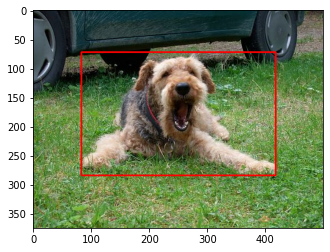

In [315]:
print('label : ',item['label'])
image = copy.deepcopy(item['image'])
# print(item['objects']['bbox'])
x1, y1, x2, y2 = get_points(image, item['objects']['bbox'])
image = cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
plt.imshow(image)
plt.show()

In [224]:
# CAM, grad-CAM 생성
cam_image = generate_cam(cam_model, item)
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

In [225]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [226]:
rect = get_bbox(cam_image)
rect

array([[ 49, 277],
       [ 79,   7],
       [413,  44],
       [383, 314]])

In [227]:
# 바운딩 박스 좌표 (정규화된 상대 좌표)
bbox = item['objects']['bbox']

# 이미지 크기
image_height, image_width = item['image'].shape[:2]

# 좌표 변환 (정규화된 좌표를 이미지 크기에 맞게 변환)
x1 = int(bbox[0, 1] * image_width)
y1 = int(bbox[0, 0] * image_height)
x2 = int(bbox[0, 3] * image_width)
y2 = int(bbox[0, 2] * image_height)


image = cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2) # 찐라벨...

#### CAM pred_bbox

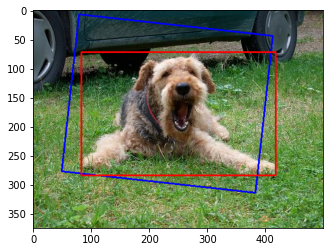

In [228]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
image = cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2) # 찐라벨...
plt.imshow(image)
plt.show()

red : origianl bbox

blue : CAM contours

In [229]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
#     bbox = [
#         rect[:,1].min()/float(image.shape[0]),
#         rect[:,0].min()/float(image.shape[1]), 
#         rect[:,1].max()/float(image.shape[0]), 
#         rect[:,0].max()/float(image.shape[1]) 
#     ]
    
    bbox = [
        rect[:,0].min(),
        rect[:,1].min(), 
        rect[:,0].max(), 
        rect[:,1].max() 
    ]
    
    return bbox


In [230]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[49, 7, 413, 314]

In [231]:
[a,b,c,d] = [int(x) if x > 0 else 0 for x in pred_bbox]
a,b,c,d

(49, 7, 413, 314)

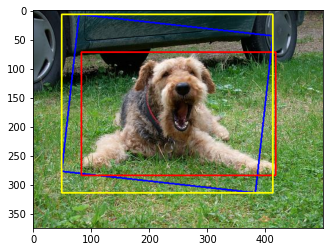

In [232]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
image = cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2) # 찐라벨...
image = cv2.rectangle(image, (a, b), (c, d), (255,255,0), 2) 
plt.imshow(image)
plt.show()

red : origianl bbox

blue : CAM contours

yellow : CAM bbox

#### Grad-CAM pred_bbox

In [244]:
low_indicies = grad_cam_image <= 0.5
grad_cam_image[low_indicies] = 0
grad_cam_image = (grad_cam_image*255).astype(np.uint8)

In [246]:
contours,_ = cv2.findContours(grad_cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
rotated_rect = cv2.minAreaRect(cnt)
rect = cv2.boxPoints(rotated_rect)
rect = np.int0(rect)
rect

array([[185, 225],
       [248,  66],
       [375, 117],
       [312, 276]])

In [248]:
pred_bbox2 = rect_to_minmax(rect,item['image'])
pred_bbox2

[185, 66, 375, 276]

In [241]:
rect = get_bbox(grad_cam_image)
rect

array([[438,   0],
       [499,   0],
       [499,  46],
       [438,  46]])

In [249]:
def pred_rect(cam_image, origin, score_thresh=0.05):
    rect = get_bbox(cam_image)
    pred_bbox = rect_to_minmax(rect, origin)
    [a,b,c,d] = pred_bbox
    return a, b, c, d

In [332]:
x, y, z, h = pred_rect(grad_cam_image, item['image'], score_thresh=0.05)
x, y, z, h

(185, 66, 375, 276)

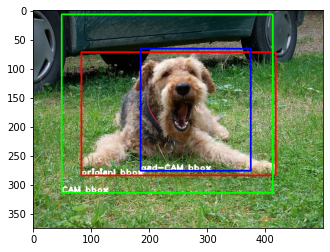

In [333]:
image = copy.deepcopy(item['image'])
cv2.putText(image, "origianl bbox", (x1, y2), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2)  
image = cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2) # 찐라벨...
cv2.putText(image, "CAM bbox", (a, d), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2)  
image = cv2.rectangle(image, (a, b), (c, d), (0,255,0), 2) #CAM
cv2.putText(image, "gad-CAM bbox", (x, h), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2)  
image = cv2.rectangle(image, (x, y), (z, h), (0,0,255), 2) #Grad-CAM
plt.imshow(image)
plt.show()

blue  : grad-CAM bbox

green : CAM bbox

red   : original bbox 


``` python
def draw_box(): 
    item = get_one(ds_test)
    # original 좌표 
    x1, y1, x2, y2 = get_points(item['image'], item['objects']['bbox'])
    # CAM, grad-CAM 생성
    cam_image = generate_cam(cam_model, item)
    grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
    # AM bbox 좌표
    a, b, c, d = pred_rect(cam_image, item['image'], score_thresh=0.05)
    # grad-CAM bbox 좌표
    x, y, z, h = pred_rect(grad_cam_image, item['image'], score_thresh=0.05)
    
#     plt.figure(figsize = (7,5))
    image = copy.deepcopy(item['image'])
    
    cv2.putText(image, "origianl bbox ", (x1, y2), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2)  
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2) # 찐라벨...
    cv2.putText(image, "CAM bbox", (a, d), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2)  
    image = cv2.rectangle(image, (a, b), (c, d), (0,255,0), 2) #CAM
    cv2.putText(image, "gad-CAM bbox", (x, h), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2)  
    image = cv2.rectangle(image, (x, y), (z, h), (0,0,255), 2) #Grad-CAM
    
    return image
```

이걸로 for 문 돌리려고 했는데 약간 실패

### Calculate IOU

In [352]:
def bbox_to_minmax(bbox, image):
    scaled_bbox = [
        bbox[0]/float(image.shape[0]),
        bbox[1]/float(image.shape[1]), 
        bbox[2]/float(image.shape[0]), 
        bbox[3]/float(image.shape[1]) 
    ]
    return scaled_bbox

In [323]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [358]:
#CAM iou 소수점 이하 2자리 반올림
ciou = round(get_iou(bbox_to_minmax(pred_bbox,item['image']), item['objects']['bbox'][0]),2)
ciou

0.37

In [359]:
#grad-CAM iou 소수점 이하 2자리 반올림
giou = round(get_iou(bbox_to_minmax(pred_bbox2,item['image']), item['objects']['bbox'][0]),2)
giou

0.21

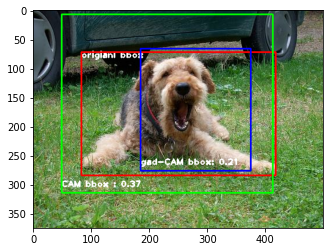

In [365]:
image = copy.deepcopy(item['image'])
cv2.putText(image, "origianl bbox", (x1, y1+10), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2)  
image = cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2) # 찐라벨...
cv2.putText(image, f"CAM bbox : {ciou}", (a, d-10), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2)  
image = cv2.rectangle(image, (a, b), (c, d), (0,255,0), 2) #CAM
cv2.putText(image, f"gad-CAM bbox: {giou}", (x, h-10), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2)  
image = cv2.rectangle(image, (x, y), (z, h), (0,0,255), 2) #Grad-CAM
plt.imshow(image)
plt.show()

In [449]:
import tqdm 

In [451]:
cam_iou = []
grad_iou = []

for item in tqdm.tqdm(ds_test.take(100)):
    cam_image = generate_cam(cam_model, item)
    grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
    
    pred_bbox = rect_to_minmax(get_bbox(cam_image),item['image'])
    pred_bbox2 = rect_to_minmax(get_bbox(grad_cam_image),item['image'])
    
    ciou = get_iou(bbox_to_minmax(pred_bbox,item['image']), item['objects']['bbox'][0])
    giou = get_iou(bbox_to_minmax(pred_bbox2,item['image']), item['objects']['bbox'][0])
    
    cam_iou.append(ciou)
    grad_iou.append(giou)
    
print('TEST 평균 CAM bbox IOU : ', np.mean(cam_iou))
print('TEST 평균 grad-CAM IOU : ', np.mean(grad_iou))

100%|██████████| 100/100 [03:27<00:00,  2.08s/it]

TEST 평균 CAM bbox IOU :  0.4150827
TEST 평균 grad-CAM IOU :  0.3264807924074122


CAM이 더 넓은 범위를 커버하기 때문에 iou가 grad-CAM보다는 높이 나오는 것으로 보임

8000개는 5시간 걸려서 100개만 했기 때문에 달라질 수는 있음

#### (additional) Comparison of grad-CAM with trained using cutmix augmentation

In [427]:
cm_model = tf.keras.models.load_model('../data_augmentation/resnet50_cm.hdf5')

In [430]:
cm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


In [433]:
cm_model.get_layer(name ='resnet50').get_layer('conv5_block3_out')

In [434]:
cm_resnet = cm_model.get_layer(name ='resnet50')

resnet50 부분이 funcational로 저장되서 못함

=> functional : functional API 에 대한 객체 이름이라 여기서 model 다루듯이 다루면 해결할 수 있었음

In [463]:
item = get_one(ds_test)

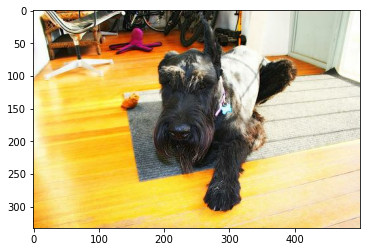

In [464]:
plt.imshow(item['image'])
plt.show()

In [465]:
grad_cm_image = generate_grad_cam(cm_resnet, 'conv5_block3_out', item)

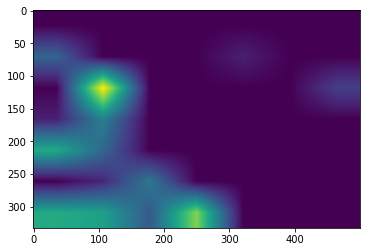

In [466]:
plt.imshow(grad_cm_image)

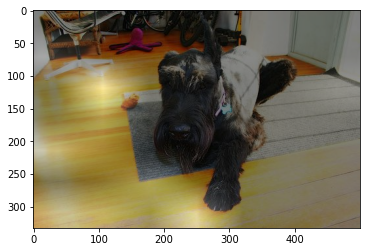

In [467]:
grad_cm_image_3channel = np.stack([grad_cm_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(grad_cm_image_3channel, item['image'])
plt.imshow(blended_image)

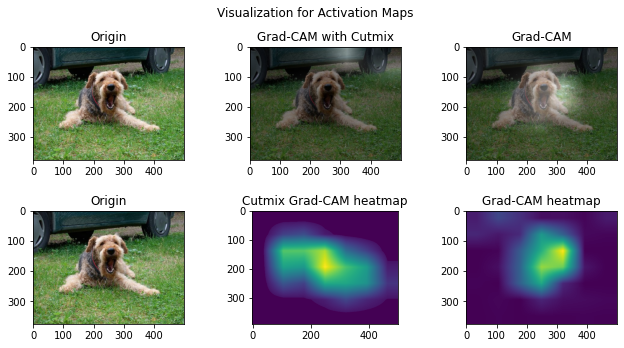

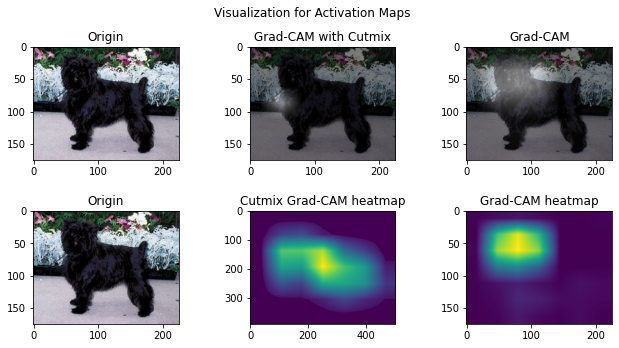

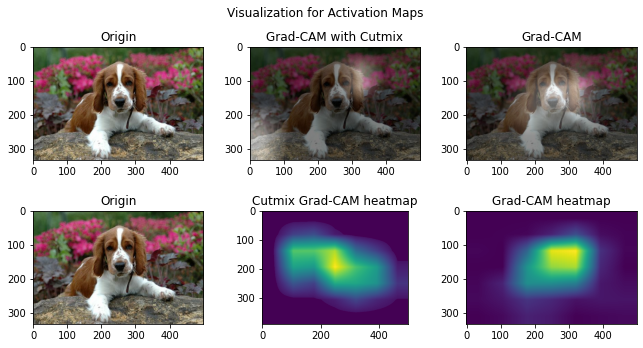

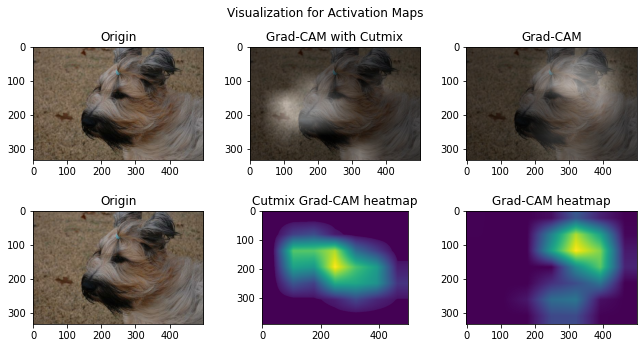

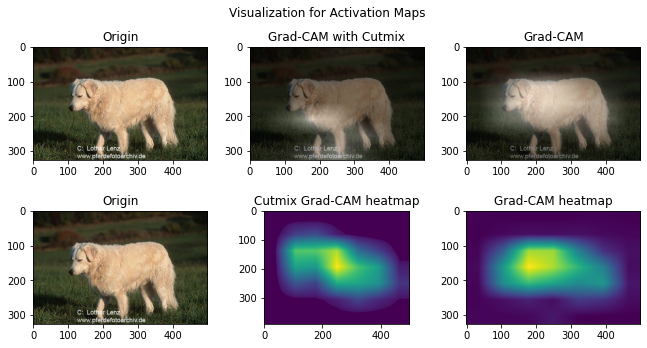

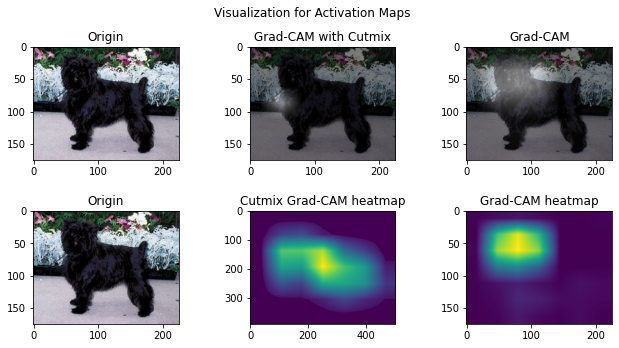

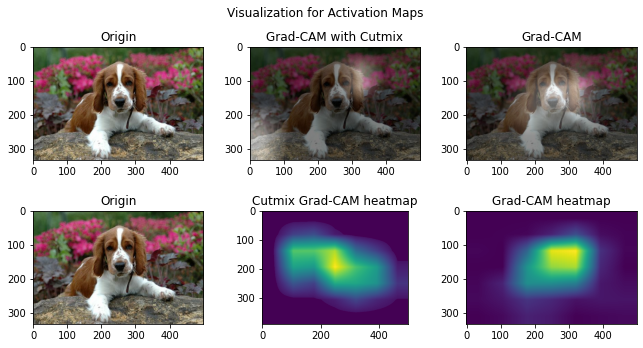

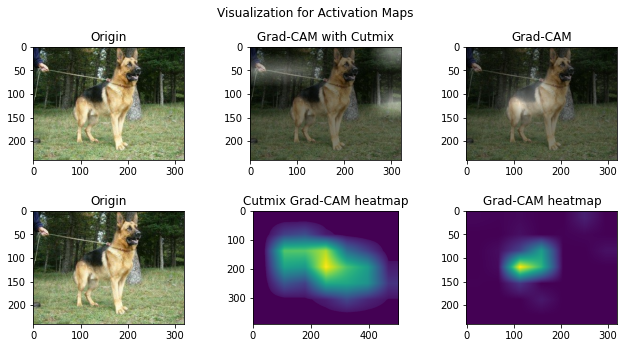

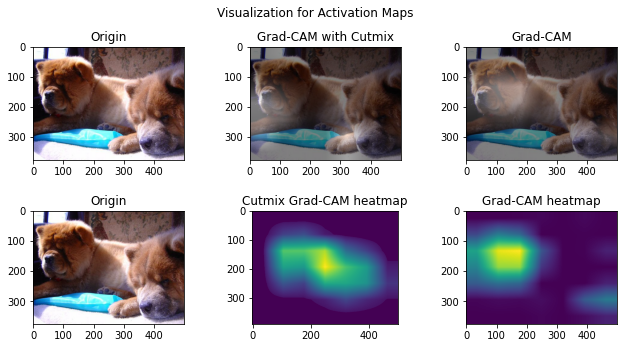

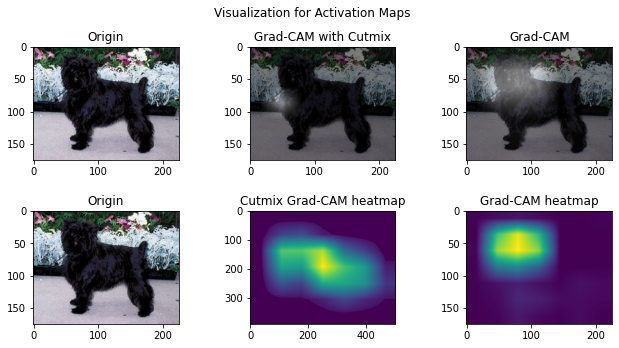

In [468]:
for _ in range(10):
    item = get_one(ds_test)
    origin_image = item['image'].astype(np.uint8)

    # CAM, grad-CAM 생성
    grad_cm_image = generate_grad_cam(cm_resnet, 'conv5_block3_out', item)
    grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

    # 3channel화
    grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
    grad_cm_image_3channel = np.stack([grad_cm_image*255]*3, axis=-1).astype(np.uint8)

    # 이미지 합성
    blended_image = visualize_cam_on_image(grad_cm_image_3channel, origin_image)
    grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

    # 시각화
    fig, ax = plt.subplots(2,3, figsize=(11,5))
    fig.suptitle(f'Visualization for Activation Maps', fontsize = 12)
    ax[0][0].imshow(origin_image)
    ax[0][0].set_title('Origin')
    ax[0][1].imshow(blended_image)
    ax[0][1].set_title('Grad-CAM with Cutmix')
    ax[0][2].imshow(grad_blended_image)
    ax[0][2].set_title('Grad-CAM')
    ax[1][0].imshow(origin_image)
    ax[1][0].set_title('Origin')
    ax[1][1].imshow(cam_image)
    ax[1][1].set_title('Cutmix Grad-CAM heatmap')
    ax[1][2].imshow(grad_cam_image)
    ax[1][2].set_title('Grad-CAM heatmap')
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=.87, wspace=0.2, hspace=0.45)
    plt.show()

cutmix를 통해 학습한 모델은 일반적인 모델이 학습한 것보다 특정 부분에 focusing 하지 못하는 모습을 보임 ==> **일반 모델보다 accuracy가 낮은 이유**로 생각됨

### 실패 노트

In [409]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [402]:
ds_batch = ds_train.take(16).map(normalize_and_resize_img).batch(16)
items = ds_batch.take(1)

In [414]:
mixed_imgs, mixed_labels = None, None
batch_size = 16
for item in items:
    for i in range(16):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
        mixed_labels = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
        break
    break
#     print(item)

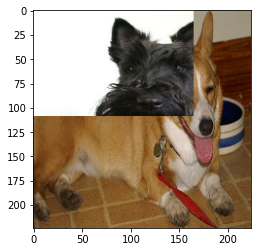

In [415]:
plt.imshow(mixed_imgs)

In [421]:

def normalize_and_resize_img2(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def apply_cutmix_on_dataset(ds, is_test=False, batch_size=16, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img2, 
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    
    # cutmix, mixup은 batch 후에 적용
    # cutmix 적용
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
            
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
            
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

위를 적용시키면 image_a not defined 에러가 계속 떠서 실패했음.

16개로 샘플 배치 만든 것에선 정상작동했음
scope문제라고는 생각 하지만 정확히는 판단 불가

이 전 노드에서는 as_supervised = True로 해서 했기때문에 시도했는데 가능.
이 차이에 대해 더 알 필요는 있음 

    as_supervised=True
    
위 경우에는 image, label만 호출하기 때문에 bbox를 그릴 수 없다.

In [417]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [422]:
ds_cutmix = apply_cutmix_on_dataset(ds_train, with_cutmix = True)

In [ ]:
cm_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cm_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

fig, ax = plt.subplots(1,2, figsize=(11,4))
fig.suptitle('Training Log')

ax[0].plot(range(len(history_cm_model.history['loss'])), history_cm_model.history['loss'], label = 'train')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(range(len(history_cm_model.history['accuracy'])), history_cm_model.history['accuracy'], label = 'train')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

cm_model.save('cm_model.h5')

import pickle

with open('cm_history.pickle','wb') as f:
    pickle.dump(history_cm_model.history,f)